In [1]:
import os
import numpy as np
import sagemaker
from sagemaker.session import s3_input

sagemaker_session = sagemaker.Session()
role = sagemaker.get_execution_role()

In [2]:
hyperparams={    'epochs': 30,
                 'learning-rate': 0.01,
                 'batch-size': 256,
                 'weight-decay': 2e-4,
                 'momentum': 0.9,
                 'optimizer': 'sgd'}

In [3]:
from sagemaker.tensorflow import TensorFlow

output_path = 's3://reinvent-aim338/'
tf_estimator = TensorFlow(entry_point='cifar10-training-script-sagemaker.py', 
                          source_dir='code',
                          role=role,
                          train_instance_count=1, 
                          train_instance_type='ml.p3.2xlarge',
                          framework_version='1.13', 
                          py_version='py3',
                          script_mode=True,
                          output_path=output_path,
                          hyperparameters=hyperparams)

train_path = 's3://reinvent-aim338/cifar10-dataset/train'
val_path = 's3://reinvent-aim338/cifar10-dataset/validation'
eval_path = 's3://reinvent-aim338/cifar10-dataset/eval'

In [4]:
tf_estimator.fit({'training': train_path,'validation': val_path,'eval': eval_path})

2019-12-05 19:13:24 Starting - Starting the training job...
2019-12-05 19:13:27 Starting - Launching requested ML instances......
2019-12-05 19:14:26 Starting - Preparing the instances for training...
2019-12-05 19:15:17 Downloading - Downloading input data...
2019-12-05 19:15:29 Training - Downloading the training image......
2019-12-05 19:16:38 Training - Training image download completed. Training in progress.2019-12-05 19:16:41,101 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2019-12-05 19:16:41,507 sagemaker-containers INFO     Invoking user script

Training Env:

{
    "additional_framework_parameters": {},
    "channel_input_dirs": {
        "eval": "/opt/ml/input/data/eval",
        "training": "/opt/ml/input/data/training",
        "validation": "/opt/ml/input/data/validation"
    },
    "current_host": "algo-1",
    "framework_module": "sagemaker_tensorflow_container.training:main",
    "hosts": [
        "algo-1"
    ],
    "hyperp

In [5]:
predictor = tf_estimator.deploy(initial_instance_count=1, instance_type='ml.c5.large')

--------------------------------------------------------------------------------------!

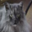

../sample-img/1014_cat.png


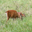

../sample-img/1003_deer.png


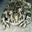

../sample-img/1009_frog.png


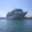

../sample-img/1004_ship.png


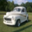

../sample-img/1005_automobile.png


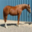

../sample-img/1037_horse.png


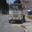

../sample-img/1008_truck.png


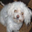

../sample-img/1000_dog.png


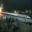

../sample-img/1001_airplane.png


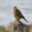

../sample-img/1038_bird.png


In [6]:
from IPython.display import Image, display

labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']
images = []
for entry in os.scandir('../sample-img'):
    if entry.is_file() and entry.name.endswith("png"):
        images.append('../sample-img/' + entry.name)

for image in images:
    display(Image(image))
    print(image)

In [7]:
predictor.content_type = 'application/x-image'
predictor.serializer = None

labels = ['airplane','automobile','bird','cat','deer','dog','frog','horse','ship','truck']

def get_prediction(file_path, pred_obj):
    
    with open(file_path, "rb") as image:
        f = image.read()
    b = bytearray(f)
    return labels[np.argmax(pred_obj.predict(b)['predictions'], axis=1)[0]]


In [8]:
predictions = [get_prediction(image, predictor) for image in images]

print('Predictions','\t\t\t','Actual')
for pred, actual in zip(predictions,images):
    print(pred,'    \t',actual)

Predictions 			 Actual
cat     	 ../sample-img/1014_cat.png
deer     	 ../sample-img/1003_deer.png
frog     	 ../sample-img/1009_frog.png
ship     	 ../sample-img/1004_ship.png
automobile     	 ../sample-img/1005_automobile.png
horse     	 ../sample-img/1037_horse.png
horse     	 ../sample-img/1008_truck.png
dog     	 ../sample-img/1000_dog.png
airplane     	 ../sample-img/1001_airplane.png
bird     	 ../sample-img/1038_bird.png


In [9]:
tf_estimator.delete_endpoint()

In [10]:
from sagemaker.tuner import IntegerParameter, CategoricalParameter, ContinuousParameter, HyperparameterTuner

hyperparameter_ranges = {
    'learning-rate': ContinuousParameter(0.0001, 0.1, scaling_type='Logarithmic'), 
    'batch-size':    CategoricalParameter([32, 128, 512, 1024]),
    'momentum':      ContinuousParameter(0.9, 0.99),
    'optimizer':     CategoricalParameter(['sgd', 'adam'])
}

objective_metric_name = 'val_acc'
objective_type = 'Maximize'
metric_definitions = [{'Name': 'val_acc', 'Regex': 'val_acc: ([0-9\\.]+)'}]

tuner = HyperparameterTuner(tf_estimator,
                            objective_metric_name,
                            hyperparameter_ranges,
                            metric_definitions,
                            strategy='Random',
                            max_jobs=8,
                            max_parallel_jobs=4,
                            objective_type=objective_type)

In [11]:
tuner.fit({'training': train_path,'validation': val_path,'eval': eval_path})

In [ ]:
tuner_predictor = tuner.deploy(initial_instance_count=1, 
                               instance_type='ml.c5.large',
                               accelerator_type='ml.eia1.medium')

2019-12-05 19:50:46 Starting - Preparing the instances for training
2019-12-05 19:50:46 Downloading - Downloading input data
2019-12-05 19:50:46 Training - Training image download completed. Training in progress.
2019-12-05 19:50:46 Uploading - Uploading generated training model
2019-12-05 19:50:46 Completed - Training job completed2019-12-05 19:39:07,436 sagemaker-containers INFO     Imported framework sagemaker_tensorflow_container.training
2019-12-05 19:39:07,437 sagemaker-containers INFO     Failed to parse hyperparameter _tuning_objective_metric value val_acc to Json.
Returning the value itself
2019-12-05 19:39:07,468 sagemaker_tensorflow_container.training INFO     Appending the training job name to model_dir: s3://reinvent-aim338/tensorflow-training-2019-12-05-19-13-24-229/model/tensorflow-training-191205-1936-004-fda01c5f/model
2019-12-05 19:39:07,785 sagemaker-containers INFO     Failed to parse hyperparameter _tuning_objective_metric value val_acc to Json.
Returning the value

In [ ]:
tuner_predictor.content_type = 'application/x-image'
tuner_predictor.serializer = None

predictions = [get_prediction(image, tuner_predictor) for image in images]

print('Predictions','\t\t\t','Actual')
for pred, actual in zip(predictions,images):
    print(pred,'    \t',actual)

In [ ]:
tuner_predictor.delete_endpoint()